In [36]:
import numpy as np
import random
import heapq
from collections import deque
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [58]:

class CustomGridWorld:
    def __init__(self, dimension=100, obstacle_density=0.1):
        self.dimension = dimension
        self.grid = np.full((dimension, dimension), '.', dtype=str)  # '.' represents empty cells
        self.start = None
        self.goal = None
        self.total_obstacles = int(obstacle_density * dimension * dimension)
        self.place_obstacles()
        self.assign_start_goal()

    def place_obstacles(self):
        count = 0
        while count < self.total_obstacles:
            x, y = random.randint(0, self.dimension - 1), random.randint(0, self.dimension - 1)
            if (x, y) != (0, 0) and (x, y) != (self.dimension - 1, self.dimension - 1) and self.grid[x, y] == '.':
                self.grid[x, y] = 'X'  # 'X' for obstacles
                if not self.is_path_clear():
                    self.grid[x, y] = '.'  # Revert if it blocks the only path
                else:
                    count += 1

    def is_path_clear(self):
        initial_position = (0, 0)
        target_position = (self.dimension - 1, self.dimension - 1)
        stack = [initial_position]
        visited = set()

        while stack:
            x, y = stack.pop()
            if (x, y) == target_position:
                return True
            if (x, y) in visited:
                continue
            visited.add((x, y))
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if (0 <= nx < self.dimension and 0 <= ny < self.dimension and 
                    self.grid[nx, ny] == '.' and (nx, ny) not in visited):
                    stack.append((nx, ny))
        return False

    def assign_start_goal(self):
        open_cells = [(i, j) for i in range(self.dimension) for j in range(self.dimension) if self.grid[i, j] == '.']
        self.start = random.choice(open_cells)
        open_cells.remove(self.start)
        self.goal = random.choice(open_cells)

        # Mark start and goal
        self.grid[self.start] = 'S'  # Start as 'S'
        self.grid[self.goal] = 'G'  # Goal as 'G'

    def shortest_path_a_star(self):
        start, goal = self.start, self.goal
        def estimate_cost(a, b):
            return abs(a[0] - b[0]) + abs(a[1] - b[1])

        priority_queue = []
        heapq.heappush(priority_queue, (0, start))
        visited_nodes = {start: None}
        path_cost = {start: 0}

        while priority_queue:
            current_node = heapq.heappop(priority_queue)[1]
            if current_node == goal:
                return True  # Path found

            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (current_node[0] + dx, current_node[1] + dy)
                if (0 <= neighbor[0] < self.dimension and 0 <= neighbor[1] < self.dimension and self.grid[neighbor] != 'X'):
                    new_cost = path_cost[current_node] + 1
                    if neighbor not in path_cost or new_cost < path_cost[neighbor]:
                        path_cost[neighbor] = new_cost
                        priority = new_cost + estimate_cost(goal, neighbor)
                        heapq.heappush(priority_queue, (priority, neighbor))
                        visited_nodes[neighbor] = current_node

        return False  # No path found

def visualize_grid(custom_world):
    plt.figure(figsize=(10, 10))
    plt.imshow([[0.8 if cell == 'X' else 0 for cell in row] for row in custom_world.grid], cmap='gray_r')
    plt.scatter(custom_world.start[1], custom_world.start[0], color='green', label='Start', s=100)
    plt.scatter(custom_world.goal[1], custom_world.goal[0], color='red', label='Goal', s=100)
    plt.title("Custom Grid World with Obstacles")
    plt.legend()
    plt.grid(True)
    plt.show()


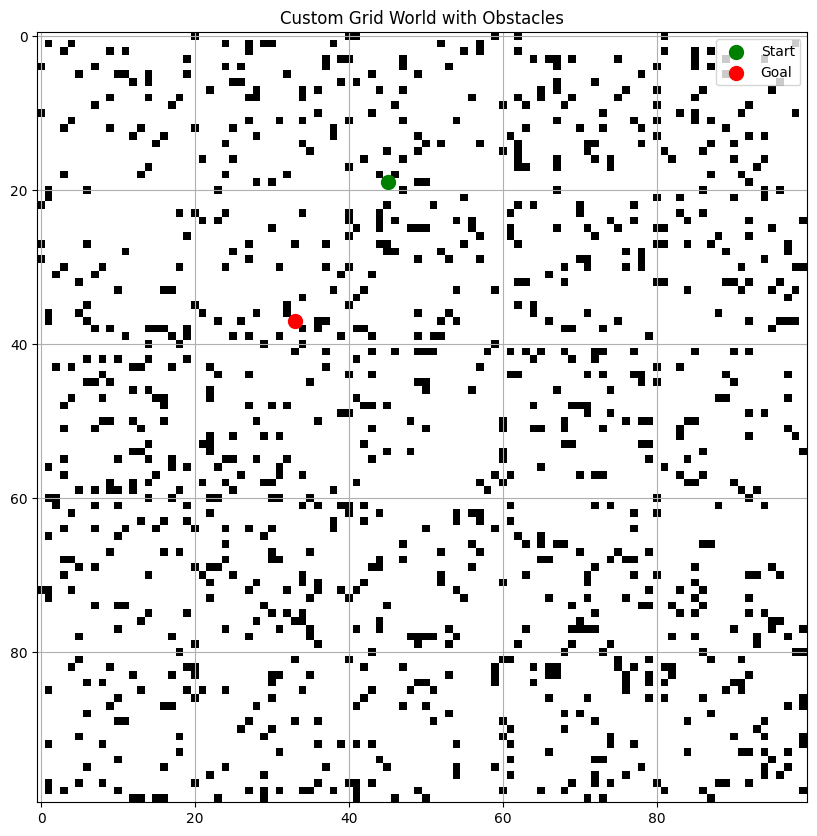

In [59]:
custom_grid_world = CustomGridWorld(dimension=100, obstacle_density=0.1)
visualize_grid(custom_grid_world)

Episode 0, Total Reward: -11093
Episode 100, Total Reward: -4034
Episode 200, Total Reward: -10796
Episode 300, Total Reward: -8321
Episode 400, Total Reward: -8285
Episode 500, Total Reward: -8321
Episode 600, Total Reward: -9311
Episode 700, Total Reward: -950
Episode 800, Total Reward: -7133
Episode 900, Total Reward: -1161


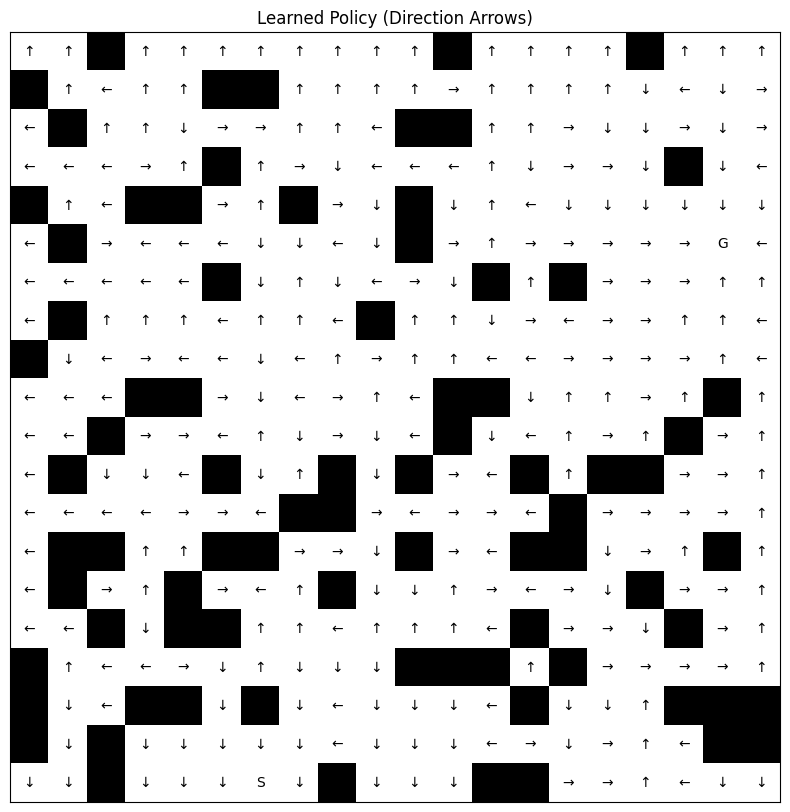

In [60]:
class MDPGridAgent:
    def __init__(self, world, learning_rate=0.1, discount_factor=0.99, epsilon=0.2):
        self.world = world
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_values = {}  # Stores Q-values for each state-action pair
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    def get_q_value(self, state, action):
        """Get the Q-value for a given state-action pair."""
        return self.q_values.get((state, action), 0.0)

    def set_q_value(self, state, action, value):
        """Set the Q-value for a given state-action pair."""
        self.q_values[(state, action)] = value

    def choose_action(self, state):
        """Epsilon-greedy action selection."""
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)
        else:
            q_values = [self.get_q_value(state, action) for action in self.actions]
            max_q = max(q_values)
            max_actions = [a for a, q in zip(self.actions, q_values) if q == max_q]
            return random.choice(max_actions)

    def get_reward(self, state):
        """Define rewards based on the environment's conditions."""
        if state == self.world.goal:
            return 100  # High reward for reaching the goal
        elif self.world.grid[state] == 'X':
            return -100  # High penalty for hitting an obstacle
        else:
            return -1  # Small penalty for each step to encourage shorter paths

    def update_q_value(self, state, action, reward, next_state):
        """Apply the Q-learning update rule."""
        current_q = self.get_q_value(state, action)
        next_max_q = max([self.get_q_value(next_state, a) for a in self.actions])
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * next_max_q)
        self.set_q_value(state, action, new_q)

    def train(self, episodes=1000, max_steps=500):
        """Train the agent over multiple episodes."""
        for episode in range(episodes):
            state = self.world.start
            steps = 0
            total_reward = 0

            while state != self.world.goal and steps < max_steps:
                action = self.choose_action(state)
                next_state = (state[0] + action[0], state[1] + action[1])

                # Ensure next state is within bounds
                if not (0 <= next_state[0] < self.world.dimension and 0 <= next_state[1] < self.world.dimension):
                    continue

                reward = self.get_reward(next_state)
                self.update_q_value(state, action, reward, next_state)

                state = next_state
                total_reward += reward
                steps += 1

            if episode % 100 == 0:
                print(f"Episode {episode}, Total Reward: {total_reward}")

    def display_policy(self):
        """Visualize the learned policy."""
        policy_grid = np.full((self.world.dimension, self.world.dimension), ' ')
        action_symbols = {
            (-1, 0): '↑', (1, 0): '↓', (0, -1): '←', (0, 1): '→'
        }

        for i in range(self.world.dimension):
            for j in range(self.world.dimension):
                state = (i, j)
                if self.world.grid[state] == 'X':
                    policy_grid[state] = 'X'
                elif state == self.world.start:
                    policy_grid[state] = 'S'
                elif state == self.world.goal:
                    policy_grid[state] = 'G'
                else:
                    best_action = max(self.actions, key=lambda a: self.get_q_value(state, a))
                    policy_grid[state] = action_symbols[best_action]

        plt.figure(figsize=(10, 10))
        plt.imshow([[0.8 if cell == 'X' else 0 for cell in row] for row in self.world.grid], cmap='gray_r')
        plt.title("Learned Policy (Direction Arrows)")
        plt.xticks([]), plt.yticks([])
        for (j, i), label in np.ndenumerate(policy_grid):
            plt.text(i, j, label, ha='center', va='center', color="black")
        plt.show()

# Create a grid world and an MDP agent for it
custom_grid_world = CustomGridWorld(dimension=20, obstacle_density=0.2)
mdp_agent = MDPGridAgent(custom_grid_world)

# Train the agent on the grid world
mdp_agent.train(episodes=1000, max_steps=500)

# Display the learned policy
mdp_agent.display_policy()

In [62]:
from tqdm import tqdm
import time

class DPAgent:
    """DP-based agent using Policy Iteration."""
    def __init__(self, world, discount_factor=0.99, theta=1e-6):
        self.world = world
        self.discount_factor = discount_factor
        self.theta = theta
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.value_table = np.zeros((world.dimension, world.dimension))

    def policy_iteration(self):
        """Apply Policy Iteration for DP."""
        stable_policy = np.zeros_like(self.value_table, dtype=int)
        
        while True:
            # Policy Evaluation
            while True:
                delta = 0
                for i in range(self.world.dimension):
                    for j in range(self.world.dimension):
                        state = (i, j)
                        if self.world.grid[state] == 'X' or state == self.world.goal:
                            continue
                        v = self.value_table[state]
                        new_value = max(self.expected_return(state, action) for action in self.actions)
                        self.value_table[state] = new_value
                        delta = max(delta, abs(v - new_value))
                if delta < self.theta:
                    break

            # Policy Improvement
            policy_stable = True
            for i in range(self.world.dimension):
                for j in range(self.world.dimension):
                    state = (i, j)
                    if self.world.grid[state] == 'X' or state == self.world.goal:
                        continue
                    old_action = stable_policy[state]
                    action_values = [self.expected_return(state, action) for action in self.actions]
                    stable_policy[state] = np.argmax(action_values)
                    if old_action != stable_policy[state]:
                        policy_stable = False
            if policy_stable:
                break
        return stable_policy

    def expected_return(self, state, action):
        """Calculate the expected return for DP."""
        next_state = (state[0] + action[0], state[1] + action[1])
        if not (0 <= next_state[0] < self.world.dimension and 0 <= next_state[1] < self.world.dimension):
            next_state = state
        reward = 100 if next_state == self.world.goal else -1 if self.world.grid[next_state] != 'X' else -100
        return reward + self.discount_factor * self.value_table[next_state]

class BenchmarkRLAgents:
    """Benchmarking different RL agents including DP, Q-learning, and SARSA."""
    def __init__(self, world):
        self.world = world

    def benchmark(self, episodes=1000):
        dp_agent = DPAgent(self.world)
        start_time = time.time()
        dp_policy = dp_agent.policy_iteration()
        dp_time = time.time() - start_time

        q_agent = MDPGridAgent(self.world)
        start_time = time.time()
        q_agent.train(episodes)
        q_time = time.time() - start_time

        sarsa_agent = MDPGridAgent(self.world, algorithm='sarsa')
        start_time = time.time()
        sarsa_agent.train(episodes)
        sarsa_time = time.time() - start_time

        return {
            "DP": {"time": dp_time, "policy": dp_policy},
            "Q-Learning": {"time": q_time, "policy": q_agent.q_values},
            "SARSA": {"time": sarsa_time, "policy": sarsa_agent.q_values}
        }

    def compare_policies(self, results):
        """Compare and visualize the learned policies for each agent."""
        plt.figure(figsize=(20, 5))

        for i, (name, result) in enumerate(results.items()):
            plt.subplot(1, 3, i + 1)
            plt.imshow(self.world.grid, cmap='gray_r')
            policy = result['policy']
            for (x, y), action in np.ndenumerate(policy):
                if self.world.grid[(x, y)] != 'X' and (x, y) not in [self.world.start, self.world.goal]:
                    plt.arrow(y, x, action[1] * 0.3, action[0] * 0.3, color='blue', head_width=0.3, head_length=0.3)
            plt.title(f"{name} Policy (Time: {result['time']:.2f}s)")
            plt.xticks([]), plt.yticks([])
        
        plt.suptitle("Policy Comparison Across DP, Q-Learning, and SARSA")
        plt.show()

# Initialize world and benchmark agents
custom_grid_world = CustomGridWorld(dimension=20, obstacle_density=0.2)
benchmark = BenchmarkRLAgents(custom_grid_world)
results = benchmark.benchmark(episodes=1000)
benchmark.compare_policies(results)

Episode 0, Total Reward: -9311
Episode 100, Total Reward: -8915
Episode 200, Total Reward: -7727
Episode 300, Total Reward: -5153
Episode 400, Total Reward: -6242
Episode 500, Total Reward: -10796
Episode 600, Total Reward: -9014
Episode 700, Total Reward: -5515
Episode 800, Total Reward: -138
Episode 900, Total Reward: 76


TypeError: MDPGridAgent.__init__() got an unexpected keyword argument 'algorithm'

In [ ]:
# Initialize the grid world
world = CustomGridWorld(dimension=100, obstacle_count=100)

# Initialize and benchmark the RL agents
benchmark = BenchmarkRLAgents(world)
results = benchmark.benchmark(episodes=1000)

# Compare and display policies of DP and Q-learning agents
benchmark.compare_policies(results)